# SentiWordNet Sentiment Analysis

In [2]:
import pandas as pd
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk import sent_tokenize, word_tokenize, pos_tag
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
df = pd.read_csv("C:/Users/Jatin/Downloads/Major Project/Dataset/Sentiment Analysis/Reviews.csv", sep = ",")
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Since we are only interested in the **Text** and **Score** of the review, therefore we will strip the dataframe.

In [4]:
df = df[["Text", "Score"]]
df.head()

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


In [5]:
num_counts = df["Score"].value_counts()
num_counts

5    363122
4     80655
1     52268
3     42640
2     29769
Name: Score, dtype: int64

In [14]:
grouped = df.groupby("Score")
new_df = pd.DataFrame(columns = ["Text", "Score"])
for name, group in grouped:
    new_df = new_df.append(group.iloc[:29769])

new_df = new_df.reset_index(drop = True)
new_df.shape

(148845, 2)

The target column **Score** contains the labels for the reviews. There are five classes in which a review is classified.

1 - negative

2 - somewhat negative

3 - neutral

4 - somewhat positive

5 - positive

## Preprocessing of text

Text Preprocessing is a process of converting and cleaning of the dataset so that it can be easily fed into the machine learning algorithm for its proper functioning and giving higher accuracy.

### Lower casing

In [18]:
new_df['Text'] = new_df['Text'].apply(lambda x: " ".join(word.lower() for word in x.split()))
new_df.head()

,Text,Score
0,product arrived labeled as jumbo salted peanut...,1
1,my cats have been happily eating felidae plati...,1
2,"the candy is just red , no flavor . just plan ...",1
3,"this oatmeal is not good. its mushy, soft, i d...",1
4,arrived in 6 days and were so stale i could no...,1


### Removing Punctuations

In [19]:
new_df['Text'] = new_df['Text'].str.replace('[^\w\s]','')
new_df.head()

,Text,Score
0,product arrived labeled as jumbo salted peanut...,1
1,my cats have been happily eating felidae plati...,1
2,the candy is just red no flavor just plan an...,1
3,this oatmeal is not good its mushy soft i dont...,1
4,arrived in 6 days and were so stale i could no...,1


### Removal of Stopwords

In [20]:
stop = stopwords.words('english')
new_df['Text'] = new_df['Text'].apply(lambda x: " ".join(y for y in x.split() if y not in stop))
new_df.head()

,Text,Score
0,product arrived labeled jumbo salted peanutsth...,1
1,cats happily eating felidae platinum two years...,1
2,candy red flavor plan chewy would never buy,1
3,oatmeal good mushy soft dont like quaker oats ...,1
4,arrived 6 days stale could eat 6 bags,1


## Using SentiWordNet

In [24]:
lemmatizer = WordNetLemmatizer()
 
 
def penn_to_wn(tag):
    """
    Convert between the PennTreebank tags to simple Wordnet tags
    """
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None
 
 
def clean_text(text):
    text = text.replace("<br />", " ")
    text = text.decode("utf-8")
 
    return text
 
 
def swn_polarity(text):
    """
    Return a sentiment polarity: 0 = negative, 1 = positive
    """
 
    sentiment = 0.0
    tokens_count = 0
 
    #text = clean_text(text)
 
 
    raw_sentences = sent_tokenize(text)
    for raw_sentence in raw_sentences:
        tagged_sentence = pos_tag(word_tokenize(raw_sentence))
 
        for word, tag in tagged_sentence:
            wn_tag = penn_to_wn(tag)
            if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
                continue
 
            lemma = lemmatizer.lemmatize(word, pos=wn_tag)
            if not lemma:
                continue
 
            synsets = wn.synsets(lemma, pos=wn_tag)
            if not synsets:
                continue
 
            # Take the first sense, the most common
            synset = synsets[0]
            swn_synset = swn.senti_synset(synset.name())
 
            sentiment += swn_synset.pos_score() - swn_synset.neg_score()
            tokens_count += 1
 
    # judgment call ? Default to positive or negative
    if not tokens_count:
        return 3
    
    else:
        return (sentiment/tokens_count)
    '''
    elif sentiment >= 0.08:
        return 5
    elif sentiment <= -0.06:
        return 1
    elif sentiment >= 0.04 and sentiment < 0.08:
        return 4
    elif sentiment <=0.02 and sentiment > -0.06:
        return 2
    else:
        return 3
    
    '''
    ## sum greater than 0 => positive sentiment
    #if sentiment >= 0:
    #    return 1
 
    ## negative sentiment
    #return 0

In [26]:
new_df["predicted_sent"] = new_df["Text"].apply(swn_polarity)
test_df

,Text,Score,predicted_sent
0,product arrived labeled jumbo salted peanutsth...,1,-0.125000
1,cats happily eating felidae platinum two years...,1,0.070652
2,candy red flavor plan chewy would never buy,1,-0.156250
3,oatmeal good mushy soft dont like quaker oats ...,1,0.100000
4,arrived 6 days stale could eat 6 bags,1,0.000000
5,buyer beware please sweetener everybody maltit...,1,-0.061012
6,tea flavor whole brunch artifial flavors retur...,1,-0.107143
7,fed golden retriever hated wouldnt eat gave te...,1,-0.031250
8,singles sell 250 336 store 1 box 24 singles im...,1,0.133929
9,seriously product tasteless come much better t...,1,0.044118


We need a boundary that is able to covert the **predicted_sent** (Predicted Sentiment score) in  an integer value between 1 to 5.

In [27]:
new_df

,Text,Score,predicted_sent
0,product arrived labeled jumbo salted peanutsth...,1,-0.125000
1,cats happily eating felidae platinum two years...,1,0.070652
2,candy red flavor plan chewy would never buy,1,-0.156250
3,oatmeal good mushy soft dont like quaker oats ...,1,0.100000
4,arrived 6 days stale could eat 6 bags,1,0.000000
5,buyer beware please sweetener everybody maltit...,1,-0.061012
6,tea flavor whole brunch artifial flavors retur...,1,-0.107143
7,fed golden retriever hated wouldnt eat gave te...,1,-0.031250
8,singles sell 250 336 store 1 box 24 singles im...,1,0.133929
9,seriously product tasteless come much better t...,1,0.044118


In [28]:
new_df.to_csv("C:/Users/Jatin/Downloads/Major Project/Dataset/Sentiment Analysis/SentiwordnetDataset.csv")

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

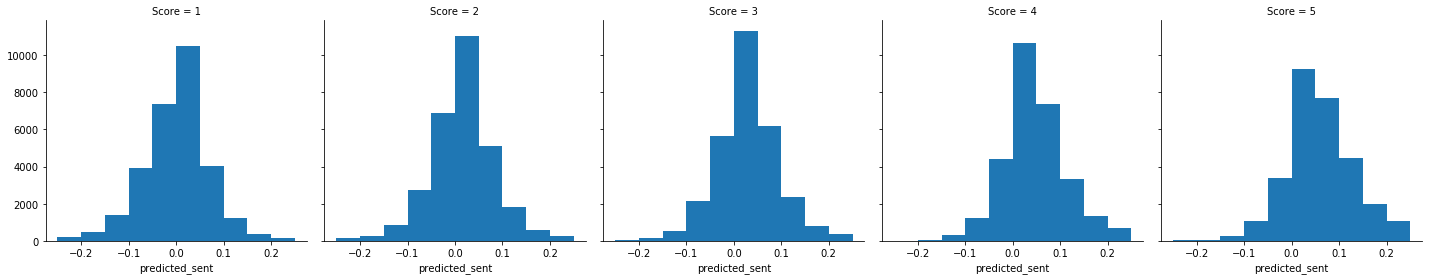

In [40]:
g = sns.FacetGrid(new_df, col = "Score", size = 4)
g.map(plt.hist, "predicted_sent", range=(-0.25, 0.25))